In [1]:
!pip install GraphRicciCurvature

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 14.3 MB/s eta 0:00:00


In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import preprocessing, metrics
import sympy as sp
from skimage import exposure
import GraphRicciCurvature
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci
import logging
import community as community_louvain
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

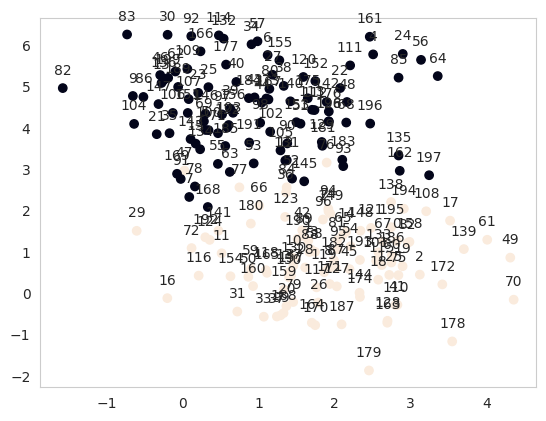

In [3]:
# generate a random 2-cluster dataset
X, y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=0, cluster_std=1.0)
plt.scatter(X[:,0], X[:,1], c=y)
for i in range(len(X)):
    plt.annotate(i, (X[i, 0], X[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.grid(False)

In [4]:
# compute distances between each point in the clusters
dist = euclidean_distances(X,X)

In [5]:
# replace distance values with zero if greater than mean threshold or 1/dist to let strong weights correspond to close distances
mean = dist.mean()
for i in range(dist.shape[0]):
    for j in range(dist.shape[1]):

        if dist[i,j] == 0:
            pass
        elif dist[i,j] > mean:
            dist[i,j] = 0
        else:
            dist[i,j] = 1/dist[i,j]

In [7]:
# generate network graph object from adjacency matrix
G = nx.from_numpy_array(dist)

In [8]:
# generate grouping data based on original clusters
group_data = {index : item for index, item in enumerate(y)}

In [9]:
# assign cluster group data to the graph
nx.set_node_attributes(G, group_data, 'group')

In [10]:
# define edge weights
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

In [11]:
def draw_graph(G, hist_eq=False):
    """
    Function to draw a network graph
    """
    # define edge colors based on weight
    cmap = plt.cm.Blues
    norm = plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
    edge_colors = [cmap(norm(weight)) for weight in edge_weights]

    # define node colors based on group
    color_map = ['lightblue' if data['group'] == 0 else 'pink' for node, data in G.nodes(data=True)]

    if hist_eq:
      # apply histogram equalization for better visual clarity among similar edge weights
      edge_colors = exposure.equalize_hist(np.asarray(edge_colors))

    # plot graph
    plt.figure(figsize=(12,8), facecolor='white')
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=600, edgecolors='black', node_shape='o', alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1)
    nx.draw_networkx_labels(G, pos, font_size=16, font_family='sans-serif',font_color='black')

    # add colorbars and titles
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm).set_label(label='Edge Weight', color='black');
    plt.title('Graph Representation of Clusters with Weighted Edges', color='black')
    plt.axis('off')
    plt.show()

<ipython-input-11-6d40c321dc0e>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm).set_label(label='Edge Weight', color='black');


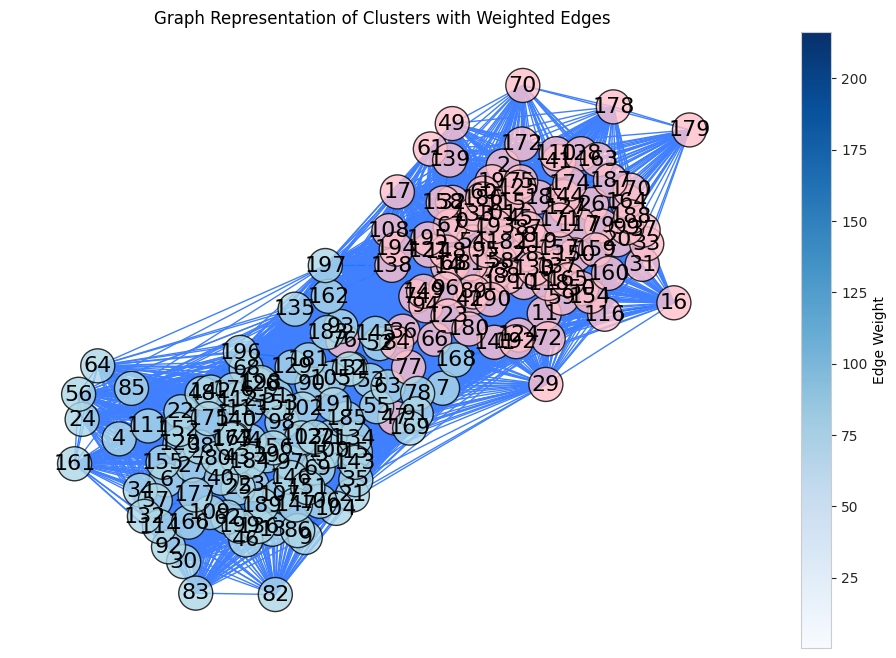

In [12]:
# plot the graph
draw_graph(G, hist_eq=True)

In [13]:
# display edges with weights
print("First five edges with corresponding weights:")
for index, (u, v, data) in enumerate(G.edges(data=True)):
    print(f"({u}, {v}) - {data}")
    if index == 4:
      break

First five edges with corresponding weights:
(0, 1) - {'weight': 0.8574906840914467}
(0, 2) - {'weight': 1.1572565708248965}
(0, 3) - {'weight': 0.6275352346124794}
(0, 8) - {'weight': 0.8991131877686126}
(0, 10) - {'weight': 0.7027503202205054}


In [14]:
# create ricci curvature object
orc = OllivierRicci(G, alpha=0.5)

In [15]:
# calculate the olliviaer-ricci curvature for each edge in the graph
orc.compute_ricci_curvature()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [16]:
# preview ricci curvature of the first few edges
print("Ricci Curvature of first 5 edges:")
for index, (u, v, data) in enumerate(orc.G.edges(data=True)):
    print(f"Edge ({u}, {v}) - Ricci Curvature: {data['ricciCurvature']}")
    if index == 4:
      break

Ricci Curvature of first 5 edges:
Edge (0, 1) - Ricci Curvature: 0.4717496613470441
Edge (0, 2) - Ricci Curvature: 0.6235711511660578
Edge (0, 3) - Ricci Curvature: 0.3770344032808455
Edge (0, 8) - Ricci Curvature: 0.5254664401903437
Edge (0, 10) - Ricci Curvature: 0.4070935913970428


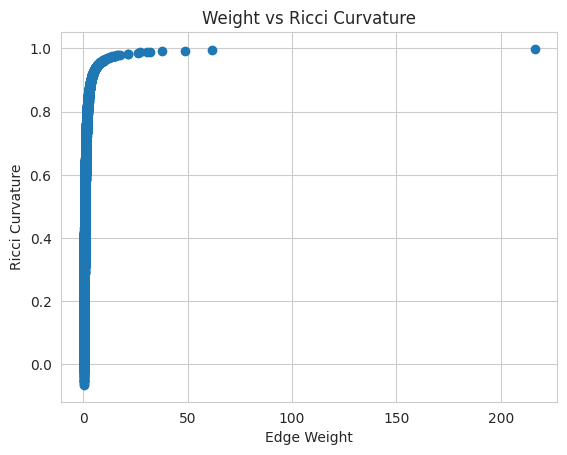

In [17]:
# extract edge data
weights = [data['weight'] for u, v, data in orc.G.edges(data=True)]
ricci_curvatures = [data['ricciCurvature'] for u, v, data in orc.G.edges(data=True)]

# generate plot of weight vs curvature
plt.plot(weights, ricci_curvatures, 'o')
plt.xlabel('Edge Weight')
plt.ylabel('Ricci Curvature')
plt.title('Weight vs Ricci Curvature')
plt.show()

In [18]:
# instantiate ricci flow object on G
orf = OllivierRicci(G, alpha=0.5, base=1, exp_power=0, proc=4, verbose="INFO")

In [19]:
# calculate ricci flow process
orf.compute_ricci_flow(iterations=5)

INFO:GraphRicciCurvature:No ricciCurvature detected, compute original_RC...
INFO:GraphRicciCurvature:24.841634 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 0 === 
INFO:GraphRicciCurvature:27.810015 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 1 === 
INFO:GraphRicciCurvature:27.905119 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 2 === 
INFO:GraphRicciCurvature:29.831660 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 3 === 
INFO:GraphRicciCurvature:27.129995 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 4 === 
INFO:GraphRicciCurvature:33.631186 secs for Ricci curvature computation.
INFO:GraphRicciCurvature:172.757341 secs for Ricci flow computation.


In [20]:
G_rf = orf.G.copy()

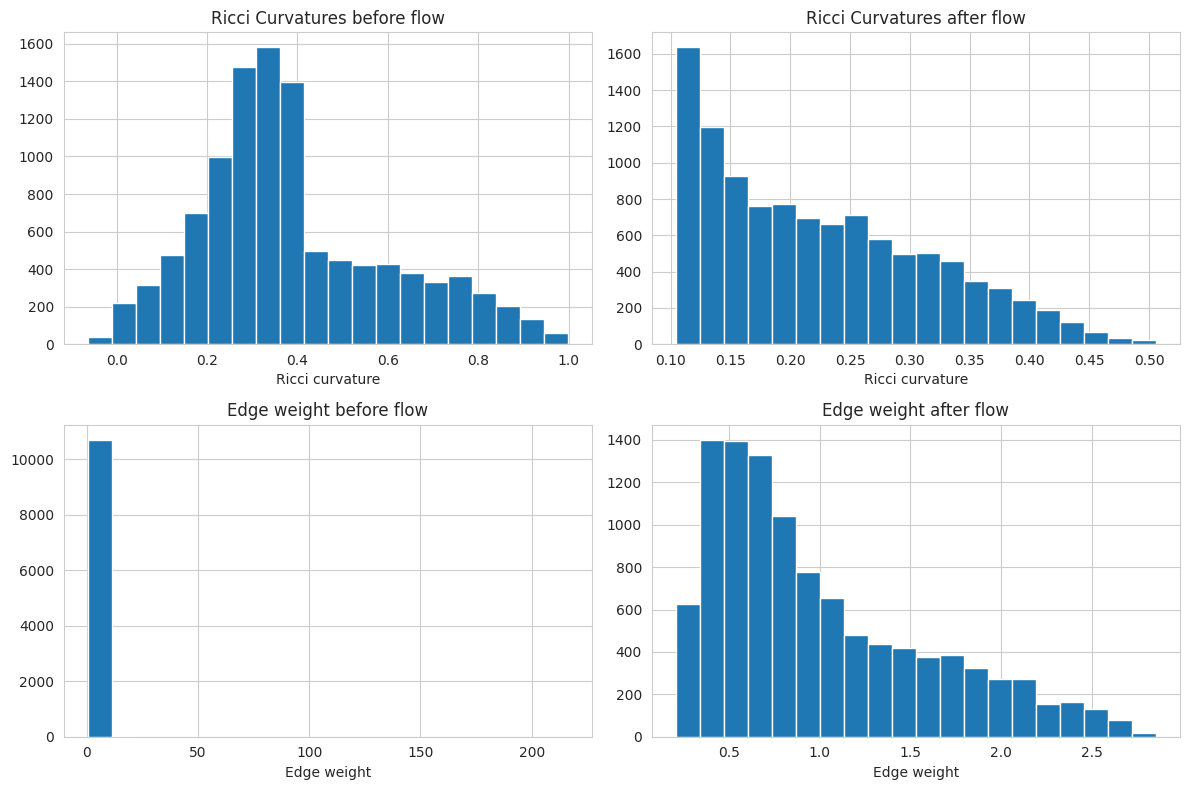

In [21]:
# histogram of Ricci curvatures
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ricci_curvtures = nx.get_edge_attributes(orc.G, "ricciCurvature").values()
axs[0, 0].hist(ricci_curvtures,bins=20)
axs[0, 0].set_xlabel('Ricci curvature')
axs[0, 0].set_title("Ricci Curvatures before flow")

ricci_curvtures = nx.get_edge_attributes(G_rf, "ricciCurvature").values()
axs[0, 1].hist(ricci_curvtures,bins=20)
axs[0, 1].set_xlabel('Ricci curvature')
axs[0, 1].set_title("Ricci Curvatures after flow")

g_weights = nx.get_edge_attributes(orc.G, "weight").values()
axs[1, 0].hist(g_weights,bins=20)
axs[1, 0].set_xlabel('Edge weight')
axs[1, 0].set_title("Edge weight before flow")

g_weights = nx.get_edge_attributes(G_rf, "weight").values()
axs[1, 1].hist(g_weights,bins=20)
axs[1, 1].set_xlabel('Edge weight')
axs[1, 1].set_title("Edge weight after flow")
plt.tight_layout()
plt.show()

<ipython-input-11-6d40c321dc0e>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm).set_label(label='Edge Weight', color='black');


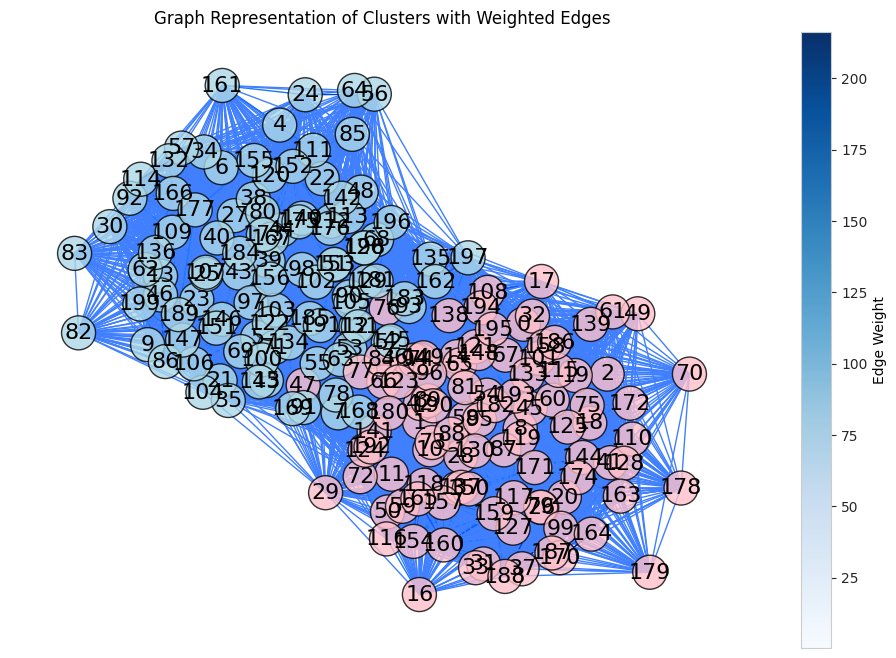

In [22]:
# visualize graph after ricci flow
draw_graph(G_rf, hist_eq=True)

In [23]:
def check_split_accuracy(G, G_rf):
    """
    Function to compute the adjusted rand index of two graph clusters
    """
    from sklearn.metrics import adjusted_rand_score
    # find connected components in G_rf
    components = list(nx.connected_components(G_rf))

    # create a dictionary that maps each node to its component label
    node_to_component = {}
    for label, comp in enumerate(components):
        for node in comp:
            node_to_component[node] = label

    # prepare label arrays for adjusted_rand_score
    true_labels = [G.nodes[node]['group'] for node in G_rf.nodes()]
    predicted_labels = [node_to_component[node] for node in G_rf.nodes()]

    # calculate the adjusted Rand index
    score = adjusted_rand_score(true_labels, predicted_labels)
    return score

In [24]:
def surgery(G_origin: nx.Graph(), weight="weight", cut=0, info=False):
    """
    Surgery function: removes edges with weight above a given threshold. Higher weights correspond with greater ricci curvatures. Ricci flow
    shrinks edges with large positive ricci curvature and stretches edges with large negative ricci curvature.

    """
    G = G_origin.copy()
    w = nx.get_edge_attributes(G, weight)

    assert cut >= 0 # cut value should be greater than 0
    if not cut:
        cut = (max(w.values()) - 1.0) * 0.6 + 1.0  # guess a cut point if a value >= 0 isnt specified

    to_cut = []
    for n1, n2 in G.edges():
        if G[n1][n2][weight] > cut:
            to_cut.append((n1, n2))

    G.remove_edges_from(to_cut)
    cc = list(nx.connected_components(G))


    if info:
      print("*************** Surgery results ****************")
      print(f"* Cut {len(to_cut)} edges.")
      print("* Number of edges now: %d" % G.number_of_edges())
      print(f"* Number of connected components now: {len(cc)}")
      print(f"* ARI now: {check_split_accuracy(G_origin, G)}")
      print("*********************************************")

    return G

In [25]:
cut_values = np.arange(0.0, 2.1, 0.05)

In [26]:
for cut in cut_values:
    H = surgery(G_rf, cut=cut)
    ari = check_split_accuracy(G, H)
    print(f"Cut={cut:.2f}, Adjusted Rand Index={ari:.4f}")

Cut=0.00, Adjusted Rand Index=0.0000
Cut=0.05, Adjusted Rand Index=0.0000
Cut=0.10, Adjusted Rand Index=0.0000
Cut=0.15, Adjusted Rand Index=0.0000
Cut=0.20, Adjusted Rand Index=0.0000
Cut=0.25, Adjusted Rand Index=0.0078
Cut=0.30, Adjusted Rand Index=0.2127
Cut=0.35, Adjusted Rand Index=0.4492
Cut=0.40, Adjusted Rand Index=0.5511
Cut=0.45, Adjusted Rand Index=0.6861
Cut=0.50, Adjusted Rand Index=0.8282
Cut=0.55, Adjusted Rand Index=0.0008
Cut=0.60, Adjusted Rand Index=0.0005
Cut=0.65, Adjusted Rand Index=0.0000
Cut=0.70, Adjusted Rand Index=0.0000
Cut=0.75, Adjusted Rand Index=0.0000
Cut=0.80, Adjusted Rand Index=0.0000
Cut=0.85, Adjusted Rand Index=0.0000
Cut=0.90, Adjusted Rand Index=0.0000
Cut=0.95, Adjusted Rand Index=0.0000
Cut=1.00, Adjusted Rand Index=0.0000
Cut=1.05, Adjusted Rand Index=0.0000
Cut=1.10, Adjusted Rand Index=0.0000
Cut=1.15, Adjusted Rand Index=0.0000
Cut=1.20, Adjusted Rand Index=0.0000
Cut=1.25, Adjusted Rand Index=0.0000
Cut=1.30, Adjusted Rand Index=0.0000
C

In [27]:
H = surgery(G_rf, cut=0.5, info=True)

*************** Surgery results ****************
* Cut 8402 edges.
* Number of edges now: 2332
* Number of connected components now: 6
* ARI now: 0.8281916605328978
*********************************************


<ipython-input-11-6d40c321dc0e>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm).set_label(label='Edge Weight', color='black');


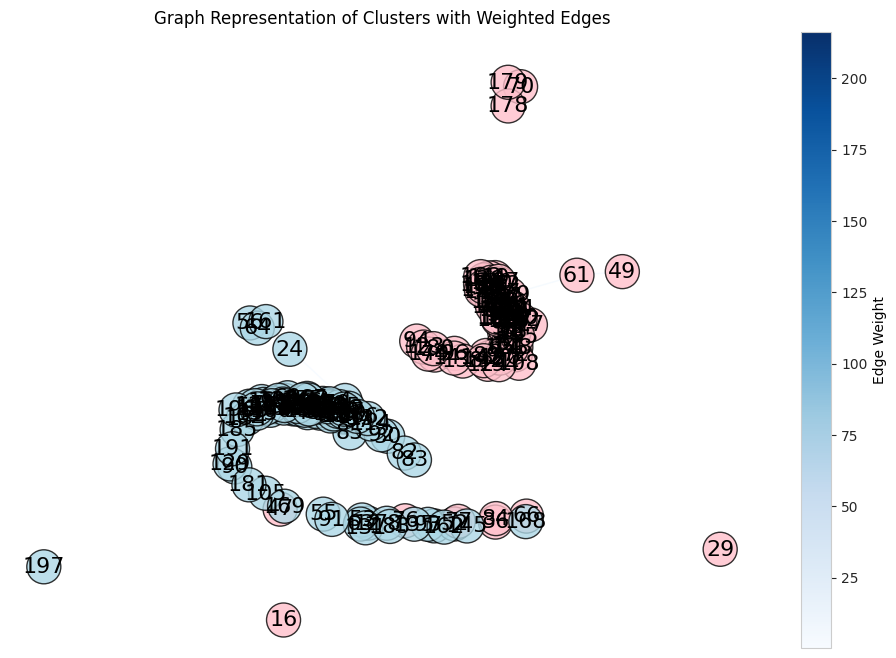

In [28]:
# visualize graph after surgery
draw_graph(H)

In [29]:
nx.number_connected_components(surgery(G_rf, cut=0.5))

6

In [30]:
nx.get_node_attributes(G, "group").values()

dict_values([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0])